TO DO : 

    - Separate data into metadata df and signal dict, so that it is easier to analyse data and to access signal just with key (sample_id) DONE
    -  Check for normal ecgs and train the classifier with AF vs normal (NORMAL ECGS ARE STATED AS SINUS RYTHM)
    - Only 100 samples are loaded for velocity. All should be loaded at the end DONE
    - If waiting time is too long use a sql based system

## Loading data

In [2]:
# !python -V > full_requirements.txt && pip list --format=freeze >> full_requirements.txt

In [3]:
import os
import wfdb  # To read the .hea file
import scipy.io as sio  # To read .mat files
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, lfilter
import numpy as np
import numpy as np 
import matplotlib.pyplot as plt 
from scipy import signal 
import pandas as pd


#Directories
dataset_dir = '../a-large-scale-12-lead-electrocardiogram-database-for-arrhythmia-study-1.0.0/WFDBRecords'

g_leads = ['I','II','III','aVR','aVL','aVF','V1','V2','V3','V4','V5','V6']
fs = 500

In [4]:
disease_map_path = '../a-large-scale-12-lead-electrocardiogram-database-for-arrhythmia-study-1.0.0/ConditionNames_SNOMED-CT.csv'
disease_map = pd.read_csv(disease_map_path)
disease_map = disease_map.set_index('Snomed_CT')
def disease_map_func(diagnosis, disease_map = disease_map):


    diagnosis = [disease_map.loc[int(code), "Full Name"] for code in diagnosis.split(',')]
    return diagnosis

In [5]:
ecg_data = {}
patient_data = {}

# Loop through each record in the dataset directory
for directory1 in sorted([dir for dir in os.listdir(f"{dataset_dir}") if not dir.startswith('.')])[0:3]: #errase the [0:3] to get all the files
    for directory2 in sorted([dir for dir in os.listdir(f"{dataset_dir}/{directory1}") if not dir.startswith('.')]):
        for record_hea in [dir for dir in os.listdir(f"{dataset_dir}/{directory1}/{directory2}") if not dir.startswith('.')]:
            if record_hea.endswith(".hea"):  # Process .hea files
                try:
                    patient_id = record_hea.split(".hea")[0]
                    record_path = f"{dataset_dir}/{directory1}/{directory2}/{patient_id}"

                    # Read the header (.hea) file
                    record = wfdb.rdheader(record_path)

                    # Extract metadata
                    age = None
                    sex = None
                    diagnosis = None
                    for comment in record.comments:
                        if comment.startswith("Age:"):
                            age = comment.split(":")[1].strip()
                        if comment.startswith("Sex:"):
                            sex = comment.split(":")[1].strip()
                        if comment.startswith("Dx:"):
                            diagnosis = comment.split(":")[1].strip()  # This gives you the SNOMED codes
                    
                    # Read the 12-lead ECG signal from the .mat file
                    mat_file_path = f"{record_path}.mat"
                    mat_data = sio.loadmat(mat_file_path)
                    ecg_signals = mat_data['val']  # 'val' typically holds the ECG signal in PhysioNet datasets
                    ecg_signals= pd.DataFrame(ecg_signals.T, columns  = g_leads)
                    # Store the data in the dictionary
                    ecg_data[patient_id] = {
                        "ecg_signals": ecg_signals,  # 12-lead ECG signals
                        }
                    patient_data[patient_id] = {
                        "diagnosis_code": [disease for disease in diagnosis.split(',')],  # Disease label (SNOMED codes)
                        "diagnosis_name": disease_map_func(diagnosis),
                        "age": age,
                        "sex": sex
                    }
                except Exception as e:
                    print(f"{patient_id}: {e}")

patient_data=pd.DataFrame(patient_data).T


JS00924: 67751000119106
JS01052: time data '/' does not match format '%d/%m/%Y'
JS02196: 67751000119106


In [6]:
disease_map

Acronym Name                                     Full Name
Snomed_CT                                                           
270492004         1AVB               1 degree atrioventricular block
195042002         2AVB               2 degree atrioventricular block
54016002         2AVB1     2 degree atrioventricular block(Type one)
28189009         2AVB2     2 degree atrioventricular block(Type two)
27885002          3AVB               3 degree atrioventricular block
...                ...                                           ...
713422000           AT                            Atrial Tachycardia
233896004        AVNRT  Atrioventricular  Node Reentrant Tachycardia
233897008         AVRT        Atrioventricular Reentrant Tachycardia
195101003        SAAWR       Sinus Atrium to Atrial Wandering Rhythm
55827005           LVH                  Left Ventricular Hypertrophy

[62 rows x 2 columns]

In [7]:
pd.DataFrame(patient_data).T

JS00067  \
diagnosis_code                   [164889003, 55827005, 428750005]   
diagnosis_name  [Atrial Fibrillation, Left Ventricular Hypertr...   
age                                                            77   
sex                                                          Male   

                                                          JS00073  \
diagnosis_code                              [426177001, 55827005]   
diagnosis_name  [Sinus Bradycardia, Left Ventricular Hypertrophy]   
age                                                            72   
sex                                                          Male   

                                                 JS00072              JS00066  \
diagnosis_code                     [426783006, 39732003]          [426177001]   
diagnosis_name  [Sinus Rhythm (Normal), Axis left shift]  [Sinus Bradycardia]   
age                                                   68                   62   
sex                                               Female                 Male   

                                           JS00099              JS00104  \
diagnosis_code              [426177001, 164934002]          [426177001]   
diagnosis_name  [Sinus Bradycardia, T wave Change]  [Sinus Bradycardia]   
age                                             49                   68   
sex                                         Female                 Male   

                                JS00070  \
diagnosis_code              [426783006]   
diagnosis_name  [Sinus Rhythm (Normal)]   
age                                  58   
sex                                Male   

                                                          JS00064  \
diagnosis_code                   [164889003, 55827005, 164934002]   
diagnosis_name  [Atrial Fibrillation, Left Ventricular Hypertr...   
age                                                            71   
sex                                                        Female   

                                JS00058                           JS00059  \
diagnosis_code              [426783006]            [427084000, 428750005]   
diagnosis_name  [Sinus Rhythm (Normal)]  [Sinus Tachycardia, ST-T Change]   
age                                  63                                39   
sex                              Female                            Female   

                ...                                            JS03105  \
diagnosis_code  ...                   [426177001, 55827005, 164934002]   
diagnosis_name  ...  [Sinus Bradycardia, Left Ventricular Hypertrop...   
age             ...                                                 83   
sex             ...                                               Male   

                            JS03111  \
diagnosis_code          [427084000]   
diagnosis_name  [Sinus Tachycardia]   
age                              58   
sex                          Female   

                                                          JS03071  \
diagnosis_code                   [164889003, 428750005, 75532003]   
diagnosis_name  [Atrial Fibrillation, ST-T Change, ventricular...   
age                                                            89   
sex                                                        Female   

                                                          JS03065  \
diagnosis_code                              [426177001, 55827005]   
diagnosis_name  [Sinus Bradycardia, Left Ventricular Hypertrophy]   
age                                                            58   
sex                                                          Male   

                                                          JS03059  \
diagnosis_code                             [426783006, 251199005]   
diagnosis_name  [Sinus Rhythm (Normal), countercolockwise rota...   
age                                                            78   
sex                                                        Female   

                            JS0

## Funcitons

In [8]:
from scipy import signal
import scipy
import random
from scipy.signal import find_peaks, welch

def temp_freq_plot(signal, title):

    fig,ax = plt.subplots(12,2, figsize=(20,12*4))
    for i in range(0,12):
        _key = g_leads[i]
        #ax[i].set_title(_key)
        ax[i,0].plot(signal[_key], color='black', linewidth=0.6)
        ax[i,0].set_ylim((-1500,1500))
        ax[i,0].set_xticks(   np.arange(0,5001,500)  )   
        ax[i,0].set_xticklabels(   np.arange(0,5001,500)/fs  )   
        ax[i,0].grid(axis='x')
        ax[i,0].annotate(_key,(-200,0))
        #ax[i].set_xlabel('Time(sec)')
        #ax[i].set_ylabel('mV')
        ax[i,0].hlines(0,0,5000,color='black', linewidth=0.3)

        frequencies, psd_values = welch( signal[_key], fs, nperseg=1024)

        # Plotting the estimated PSD
        ax[i,1].semilogy(frequencies, psd_values)
        ax[i,1].set_title('Power Spectral Density (PSD) Estimate using Welch\'s Method')
        ax[i,1].set_xlabel('Frequency (Hz)')
        ax[i,1].set_ylabel('PSD (V^2/Hz)')

    plt.suptitle(f"{title}")
    plt.tight_layout()
    plt.show()




def butter_highpass(cutoff, fs, order=5):
    nyquist = 0.5 * fs  # Nyquist frequency
    normal_cutoff = cutoff / nyquist  # Normalize cutoff frequency
    b, a = signal.butter(order, normal_cutoff, btype='high', analog=False)
    return b, a

def highpass_filter(data, cutoff, fs, order=5):
    b, a = butter_highpass(cutoff, fs, order=order)
    y = signal.filtfilt(b, a, data)
    return y

def butter_lowpass(cutoff, fs, order=5):
    nyquist = 0.5 * fs  # Nyquist frequency
    normal_cutoff = cutoff / nyquist  # Normalize cutoff frequency
    b, a = signal.butter(order, normal_cutoff, btype='lowpass', analog=False)
    return b, a

def lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = signal.filtfilt(b, a, data)
    return y

# Design a Notch Filter to remove 60 Hz power line interference
def notch_filter(frequency, fs, quality_factor=30):
    b, a = signal.iirnotch(frequency, quality_factor, fs)
    return b, a

def apply_notch_filter(data, frequency, fs, quality_factor=30):
    b, a = notch_filter(frequency, fs, quality_factor)
    y = signal.filtfilt(b, a, data)
    return y


def scipy_notch_filter(data, fs, frequency, quality):
    return scipy.signal.filtfilt(*scipy.signal.iirnotch(frequency / (fs / 2), quality), data)



## Signal filtering pipeline

Frequency response and plot of random patient

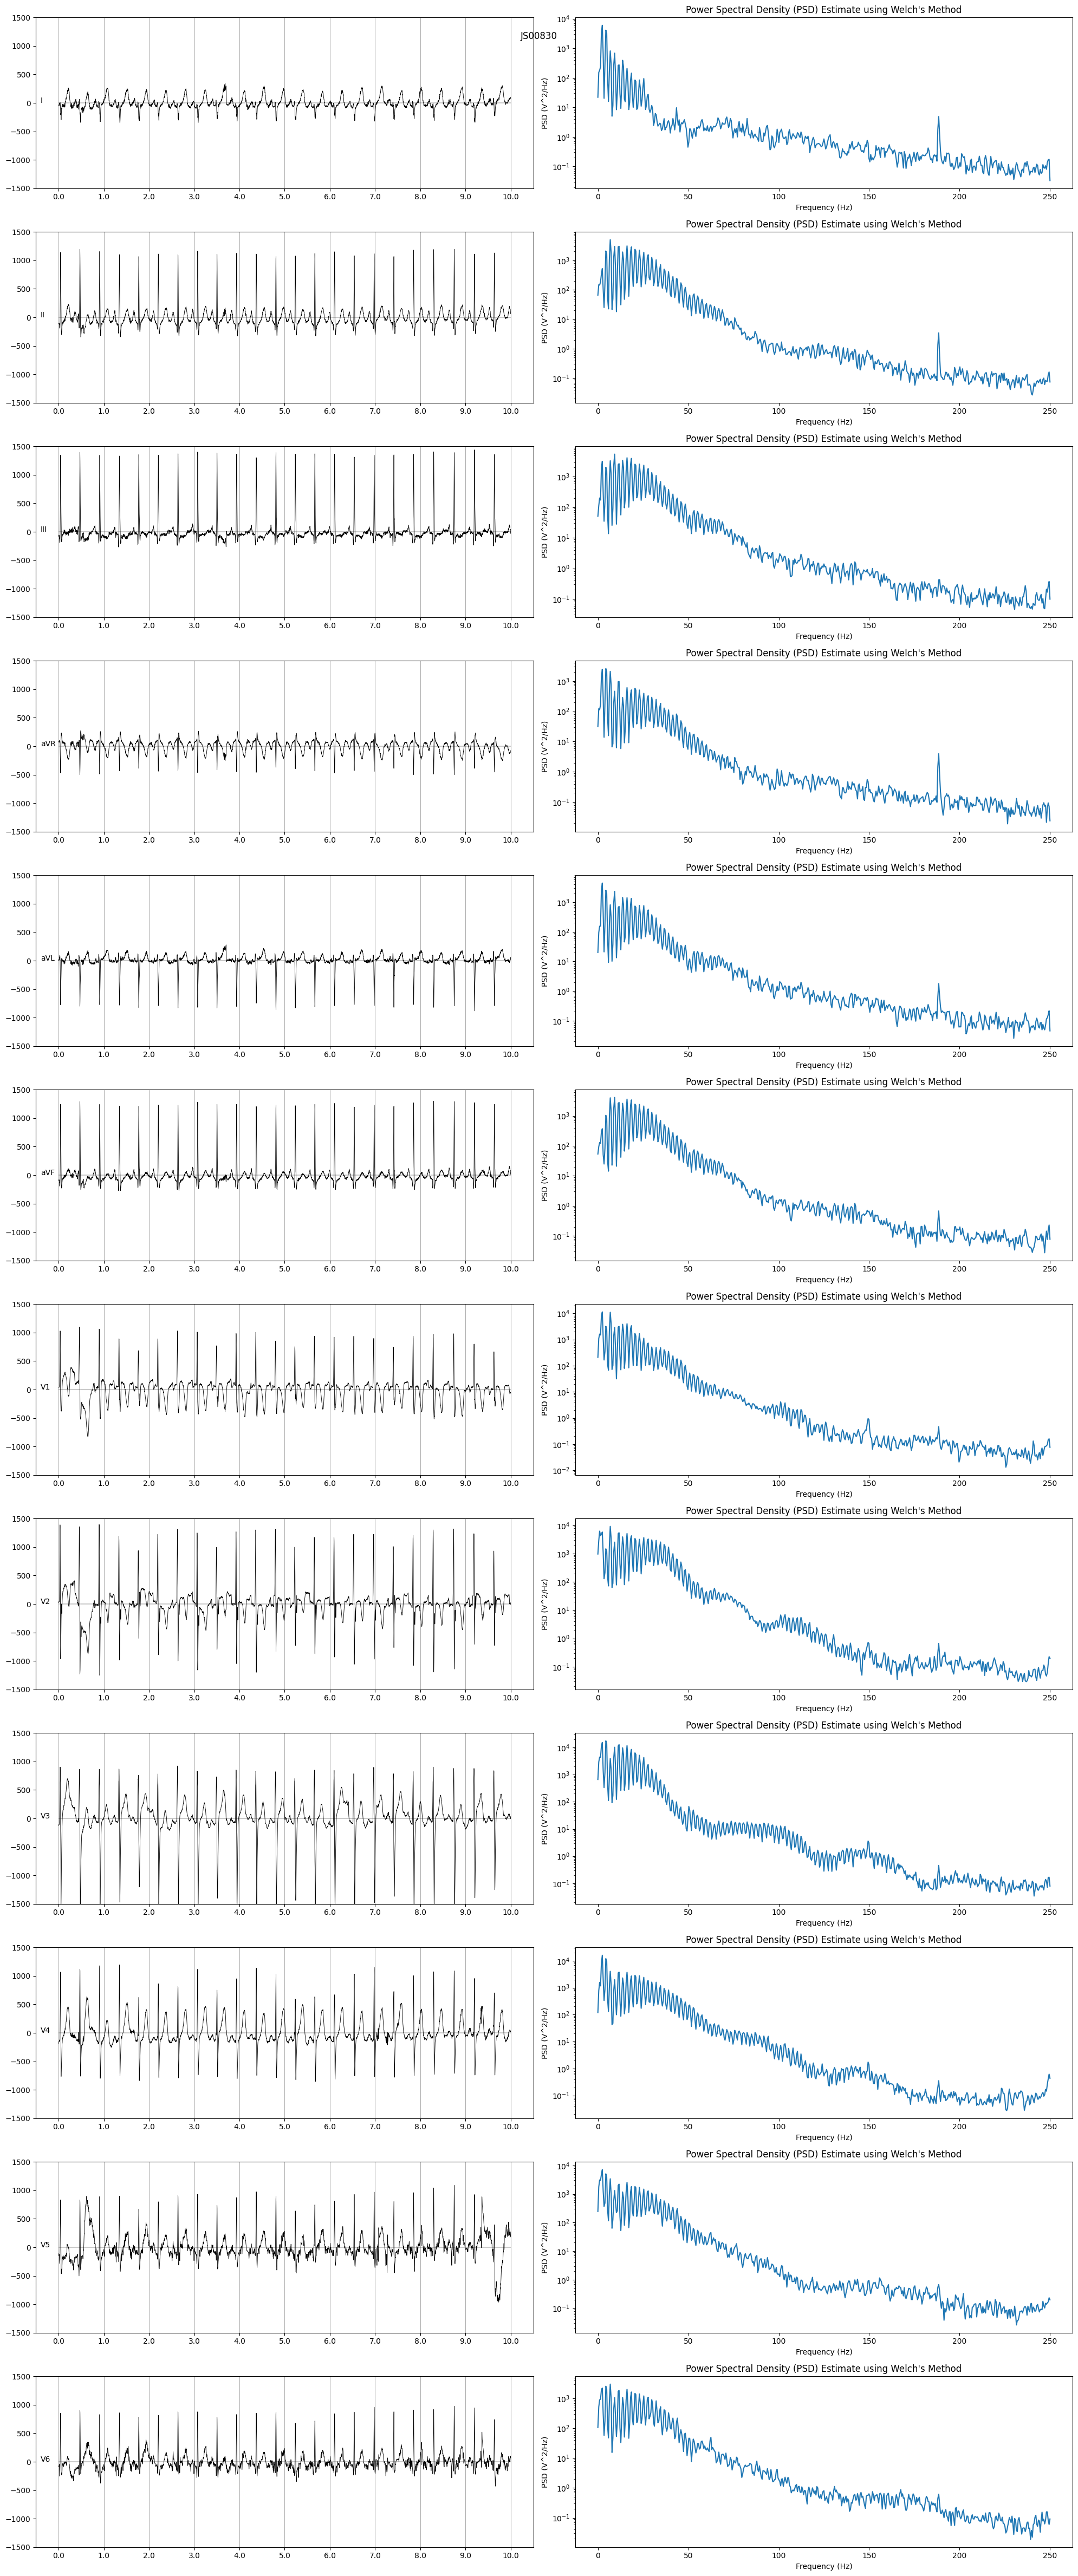

In [9]:
np.random.seed(42)  # Ensure reproducibility

random_patient = random.choice(list(ecg_data.keys()))
patient_signal = ecg_data[random_patient]["ecg_signals"]

temp_freq_plot(signal = patient_signal, title=random_patient)

In [10]:
#applying filters
for patient in ecg_data.keys():

    filtered_signal = ecg_data[patient]['ecg_signals']#.apply(lambda x: signal.detrend(x))
    filtered_signal= filtered_signal.apply(lambda x:  signal.detrend(x))
    filtered_signal = filtered_signal.apply(lambda x: highpass_filter(data = x, cutoff=5, fs=fs))

    filtered_signal = filtered_signal.apply(lambda x: lowpass_filter(data = x, cutoff=140, fs=fs))
    filtered_signal = filtered_signal.apply(lambda x: scipy_notch_filter(data=x, frequency=50, fs=fs, quality=30))
    ecg_data[patient]['ecg_signals_filtered'] = filtered_signal



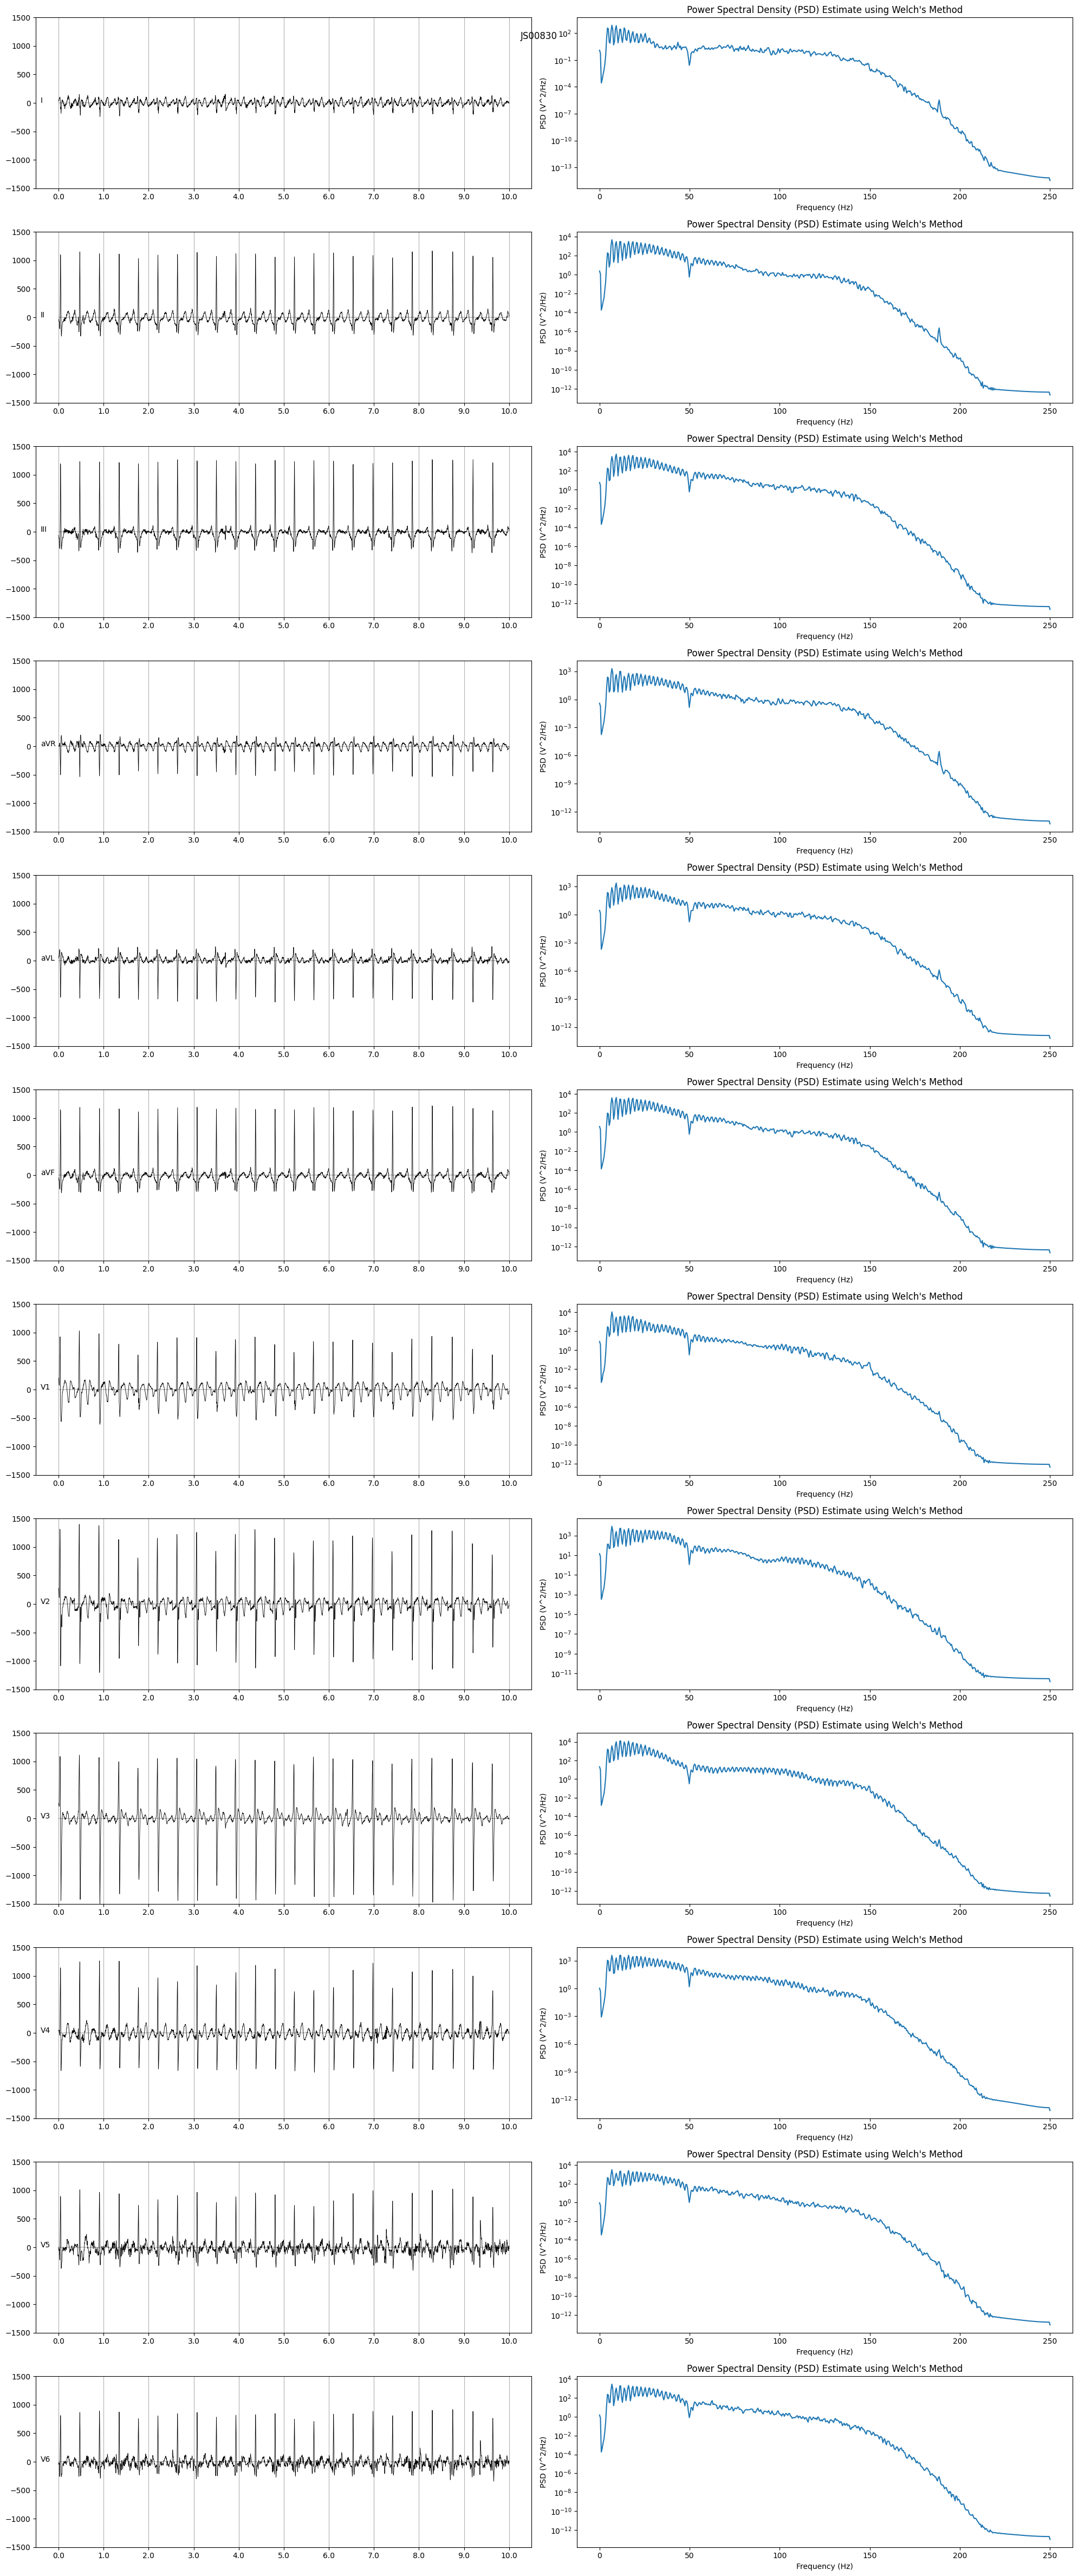

In [11]:
patient_signal_filtered = ecg_data[random_patient]['ecg_signals_filtered']

temp_freq_plot(signal = patient_signal_filtered, title = random_patient)

## Illness distribution and data filtering

In [12]:
import sys
sys.path.append('/Users/marcpalomer/Documents/Personal/ECG_prediction/utils')
import auto_EDA as eda 
%matplotlib inline


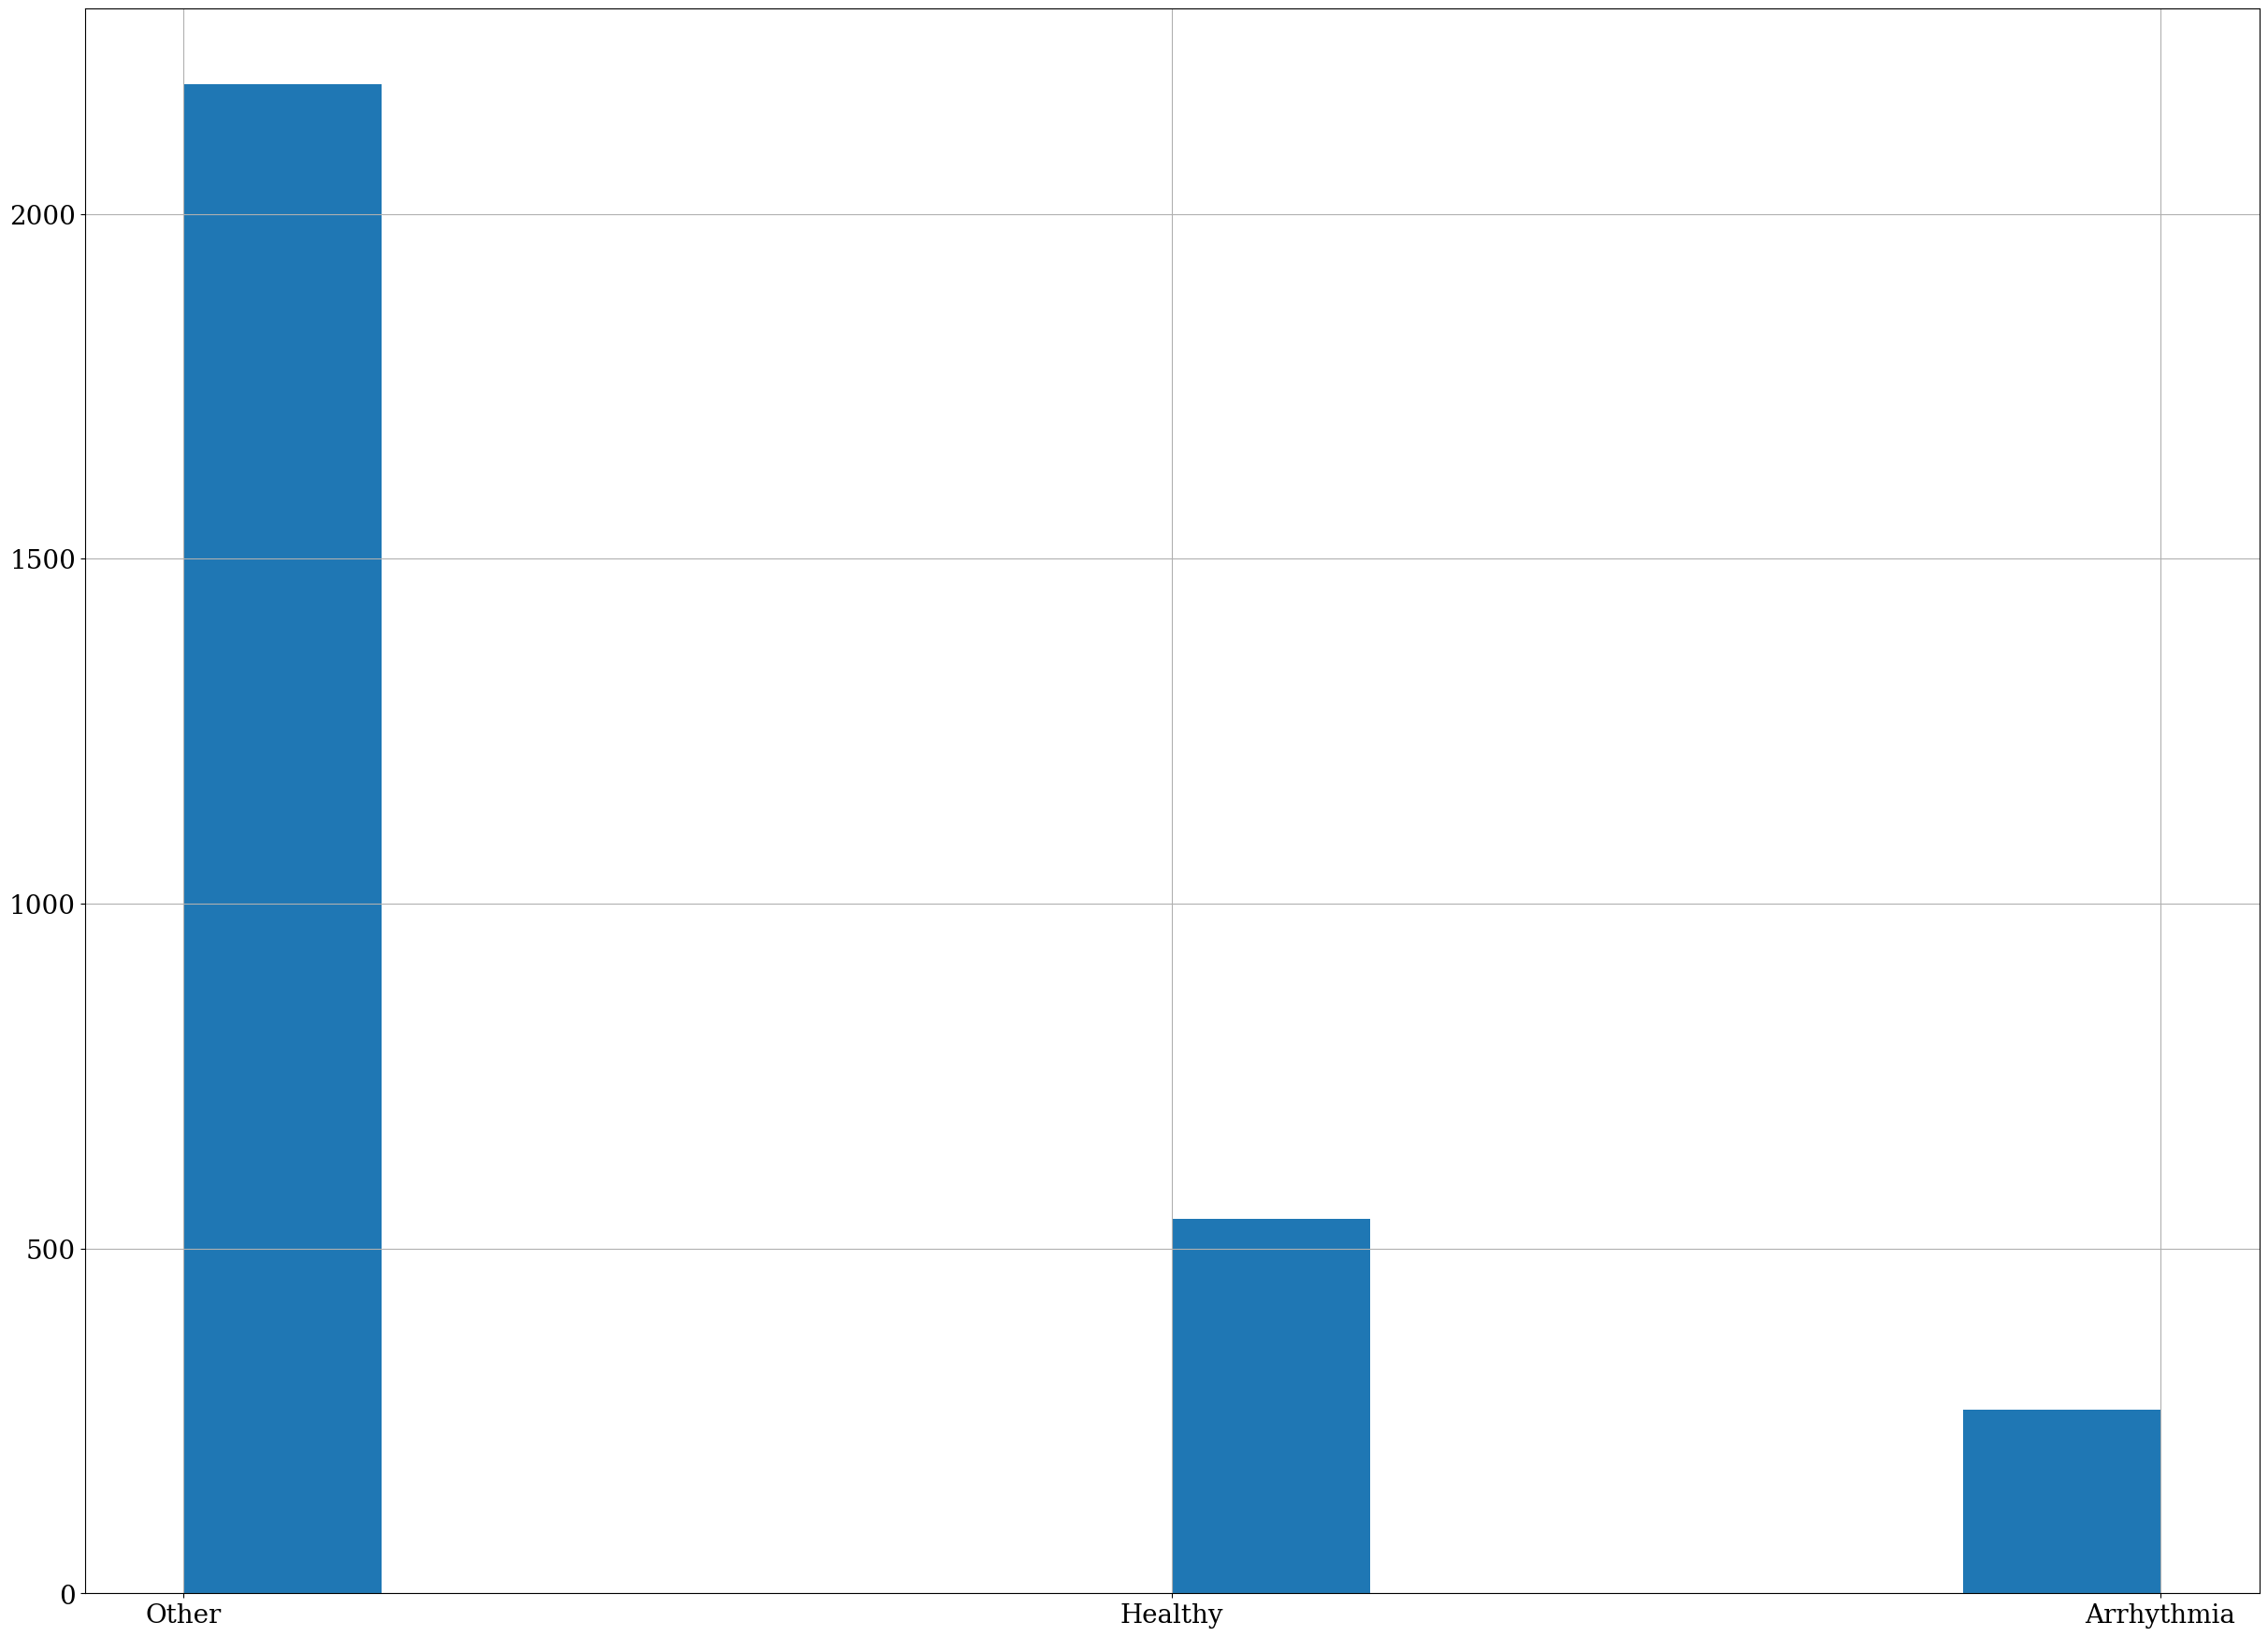

In [13]:
def classify_arrhythmia(diagnosis_codes):
   # Arrhythmia SNOMED codes
    #    snomed_codes = {
    #    'AF': '49436004',
    #    'RBBB': '59118001', 
    #    'LBBB': '28189009',
    #    'IAVB': '270492004',
    #    'PAC': '284470004',
    #    'PVC': '427172004',
    #    'MI': '22298006'
    #}
   arrhythmia_codes = ['49436004', '59118001', '28189009', '270492004', '284470004', '427172004', '22298006']
   
   # Sinus Rhythm Normal code
   healthy_code = '426783006'
   
   # Check if any arrhythmia code is present
   if any(code in diagnosis_codes for code in arrhythmia_codes):
       return 'Arrhythmia'
   # Check if healthy code present
   elif healthy_code in diagnosis_codes:
       return 'Healthy'
   # Otherwise other
   else:
       return 'Other'

# Apply to dataframe
patient_data['arrhythmia'] = patient_data['diagnosis_code'].apply(classify_arrhythmia)
patient_data['arrhythmia'].hist()
plt.show()

### HRV calculation in lead II (gold standard) (it is a time saries for patient so like a new lead...)

In [14]:
import neurokit2 as nk
import numpy as np

def validate_rpeaks(rpeaks, fs):
    # Remove physiologically impossible R-peaks
    rr_intervals = np.diff(rpeaks) / fs
    valid_rr = (rr_intervals >= 0.2) & (rr_intervals <= 2.0)  
    valid_peaks = rpeaks[1:][valid_rr]
    return valid_peaks

def calculate_hr_metrics(rpeaks, fs):
    rr_intervals = np.diff(rpeaks) / fs
    hr = 60 / rr_intervals
    return np.median(hr), np.mean(hr), np.std(hr), np.min(hr), np.max(hr)

def calculate_heartrate(record, fs):
    # Find R-peaks using neurokit2
    rpeaks = list(nk.ecg_findpeaks(record, sampling_rate=fs).values())[0]
    rpeaks = validate_rpeaks(rpeaks, fs)
    return calculate_hr_metrics(rpeaks, fs)

def add_hr_metrics(patient_data, ecg_data):
    metrics = {'median_hr': [], 'mean_hr': [], 'std_hr': [], 'min_hr': [], 'max_hr': []}
    
    for id in patient_data.index:
        if id in ecg_data:
            lead_II = ecg_data[id]['ecg_signals_filtered'].loc[:,'II']
            try:
                median_hr, mean_hr, std_hr, min_hr, max_hr = calculate_heartrate(lead_II, fs=500)
            except:
                median_hr, mean_hr, std_hr, min_hr, max_hr = [np.nan,np.nan,np.nan,np.nan,np.nan]
            metrics['median_hr'].append(median_hr)
            metrics['mean_hr'].append(mean_hr)
            metrics['std_hr'].append(std_hr)
            metrics['min_hr'].append(min_hr)
            metrics['max_hr'].append(max_hr)
        else:
            for key in metrics:
                metrics[key].append(None)
    
    for metric, values in metrics.items():
        patient_data[metric] = values
    
    return patient_data

patient_data = add_hr_metrics(patient_data, ecg_data)

In [15]:
patient_data['Healthy'] = ['HEALTHY' if 'Health' in col else 'ILL' for col in patient_data['arrhythmia'] ]
patient_data

diagnosis_code  \
JS00067             [164889003, 55827005, 428750005]   
JS00073                        [426177001, 55827005]   
JS00072                        [426783006, 39732003]   
JS00066                                  [426177001]   
JS00099                       [426177001, 164934002]   
...                                              ...   
JS03058                                  [426177001]   
JS03070  [164889003, 164917005, 55827005, 164934002]   
JS03104                                  [427084000]   
JS03039                                  [426783006]   
JS03038            [164889003, 698252002, 164934002]   

                                            diagnosis_name age     sex  \
JS00067  [Atrial Fibrillation, Left Ventricular Hypertr...  77    Male   
JS00073  [Sinus Bradycardia, Left Ventricular Hypertrophy]  72    Male   
JS00072           [Sinus Rhythm (Normal), Axis left shift]  68  Female   
JS00066                                [Sinus Bradycardia]  62    Male   
JS00099                 [Sinus Bradycardia, T wave Change]  49  Female   
...                                                    ...  ..     ...   
JS03058                                [Sinus Bradycardia]  59  Female   
JS03070  [Atrial Fibrillation, abnormal Q wave, Left Ve...  83    Male   
JS03104                                [Sinus Tachycardia]  28    Male   
JS03039                            [Sinus Rhythm (Normal)]  68  Female   
JS03038  [Atrial Fibrillation, [Interior differences co...  80    Male   

        arrhythmia   median_hr     mean_hr     std_hr     min_hr      max_hr  \
JS00067      Other   88.121118   98.571389  26.673713  60.240964  145.631068   
JS00073      Other   56.391774   56.527697   0.988208  54.844607   58.252427   
JS00072    Healthy   63.837012   63.893781   2.918675  59.171598   69.444444   
JS00066      Other   55.147059   56.567428   2.916047  53.475936   60.851927   
JS00099      Other   57.251908   57.338853   0.713353  56.603774   58.708415   
...            ...         ...         ...        ...        ...         ...   
JS03058      Other   59.405941   58.560873   1.943822  55.762082   61.099796   
JS03070      Other  107.638889  110.567698  18.053931  74.074074  147.058824   
JS03104      Other  101.010101  100.957381   2.886363  95.541401  105.263158   
JS03039    Healthy   64.516427   65.247242   1.405285  63.559322   67.720090   
JS03038      Other  130.067568  125.585431  33.325694  62.111801  182.926829   

         Healthy  
JS00067      ILL  
JS00073      ILL  
JS00072  HEALTHY  
JS00066      ILL  
JS00099      ILL  
...          ...  
JS03058      ILL  
JS03070      ILL  
JS03104      ILL  
JS03039  HEALTHY  
JS03038      ILL  

[2997 rows x 11 columns]

In [16]:
# import automatic_reporting as AR 
# reportName = "Patient Data and HRV"
analyse_features= ['median_hr',	'mean_hr','std_hr',	'min_hr', 'max_hr', 'age']
# control_features= ['sex', 'arrhythmia', 'Healthy']




# PATH = '.'

# report_builder = AR.AutoReport(main_path = f"{PATH}",
#                                     data = patient_data,
#                                     analyse_features= analyse_features,
#                                     control_features= control_features)

# report_builder.generate_report(ReportName = reportName)

# Dumb classifier

In [17]:
ML_dataset = patient_data[analyse_features+['Healthy']]

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_validate
from sklearn.pipeline import Pipeline



def quick_classify(df, target_col, features=None):
    """
    Quick classification using RandomForest with minimal preprocessing.
    
    Args:
        df: pandas DataFrame with your data
        target_col: name of the column to predict
        features: list of feature columns to use (optional, uses all except target if None)
    """
    # Select features
    if features is None:
        features = [col for col in df.columns if col != target_col]
    
    # Prepare data
    X = df[features]
    y = df[target_col]
    
    # Handle non-numeric columns
    # X = pd.get_dummies(X)
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Train model
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train_scaled, y_train)
    
    # Evaluate
    y_pred = model.predict(X_test_scaled)
    print(classification_report(y_test, y_pred))
    
    return {
        'model': model,
        'scaler': scaler,
        'features': X.columns.tolist()
    }

In [19]:
quick_classify_dict = quick_classify(ML_dataset, target_col='Healthy')
quick_classify_dict

              precision    recall  f1-score   support

     HEALTHY       0.95      0.94      0.94       116
         ILL       0.99      0.99      0.99       484

    accuracy                           0.98       600
   macro avg       0.97      0.96      0.97       600
weighted avg       0.98      0.98      0.98       600



{'model': RandomForestClassifier(random_state=42),
 'scaler': StandardScaler(),
 'features': ['median_hr', 'mean_hr', 'std_hr', 'min_hr', 'max_hr', 'age']}

In [20]:
from sklearn.model_selection import train_test_split
import RF_pipeline

def analyze_model(df, target_col, features=None, test_size=0.2, random_state=42):
    """Main function to analyze the model."""
    if features is None:
        features = [col for col in df.columns if col != target_col]
    

    X = df[features]
    y = df[target_col]

    # Preprocess data
    X_processed = X.copy()
    for column in X_processed.columns:
        X_processed[column] = pd.to_numeric(X_processed[column], errors='coerce')
    X_processed = X_processed.fillna(X_processed.median())
    y_processed = pd.factorize(y)[0]
    
    # Split the data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X_processed, y_processed, test_size=test_size, random_state=random_state)
    
    analyzer = RF_pipeline.RandomForestAnalyzer()
    visualizer = RF_pipeline.ModelVisualizer()

    return X_train, X_test, y_train, y_test, analyzer, visualizer, features
   
X_train, X_test, y_train, y_test, analyzer, visualizer, features = analyze_model(df=ML_dataset, target_col='Healthy', features=None)

Performing OOB Analysis...


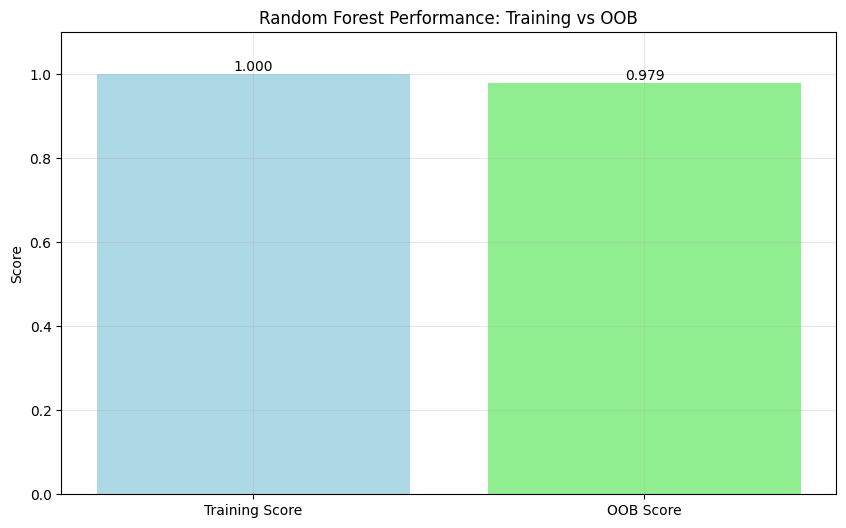


Analyzing Feature Importance...


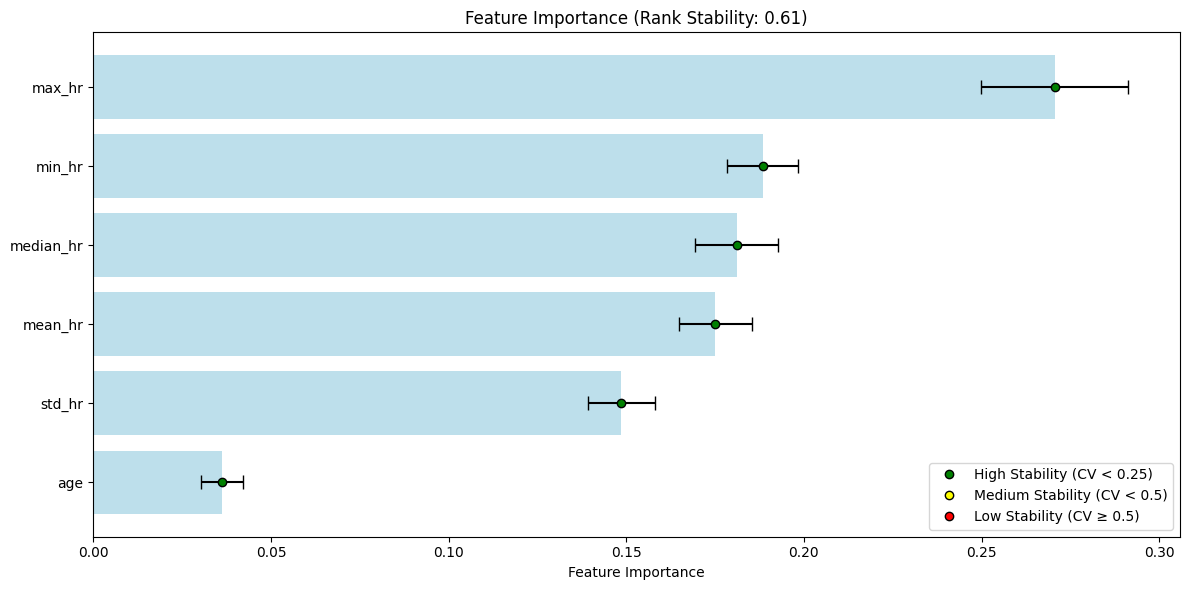


Performing Cross Validation...


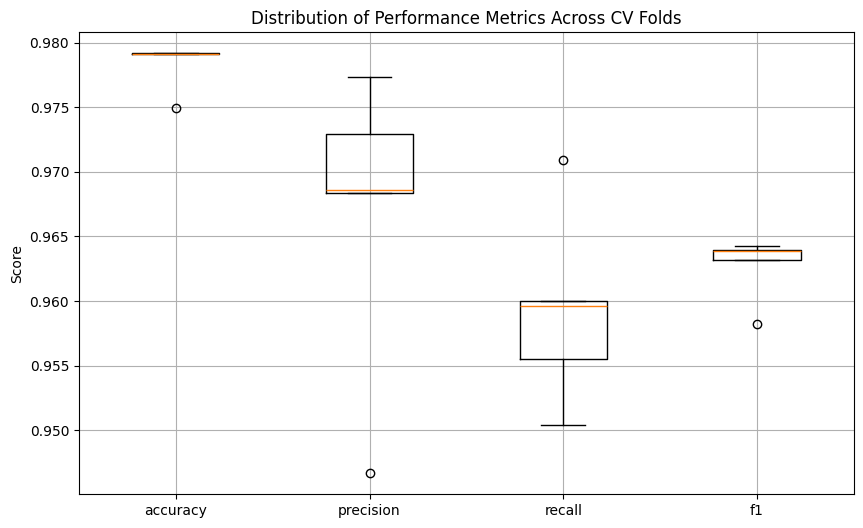

In [21]:
# OOB Analysis
print("Performing OOB Analysis...")
oob_results = analyzer.analyze_oob(X_train, y_train)
visualizer.plot_oob_analysis(oob_results)

# Feature Importance Analysis
print("\nAnalyzing Feature Importance...")
importance_results = analyzer.analyze_feature_importance(X_train, y_train)
visualizer.plot_feature_importance(importance_results)

# Cross Validation
print("\nPerforming Cross Validation...")
cv_results = analyzer.cross_validate(X_train, y_train)
visualizer.plot_cv_results(cv_results)

As we have seen, the distribution in cv of the performance metrics is better than the performance over the uncrossvalidated healthy, also pointing to the fact that the model is better at predicting the majority class than the minority. Anyway it is incredibly good at both.

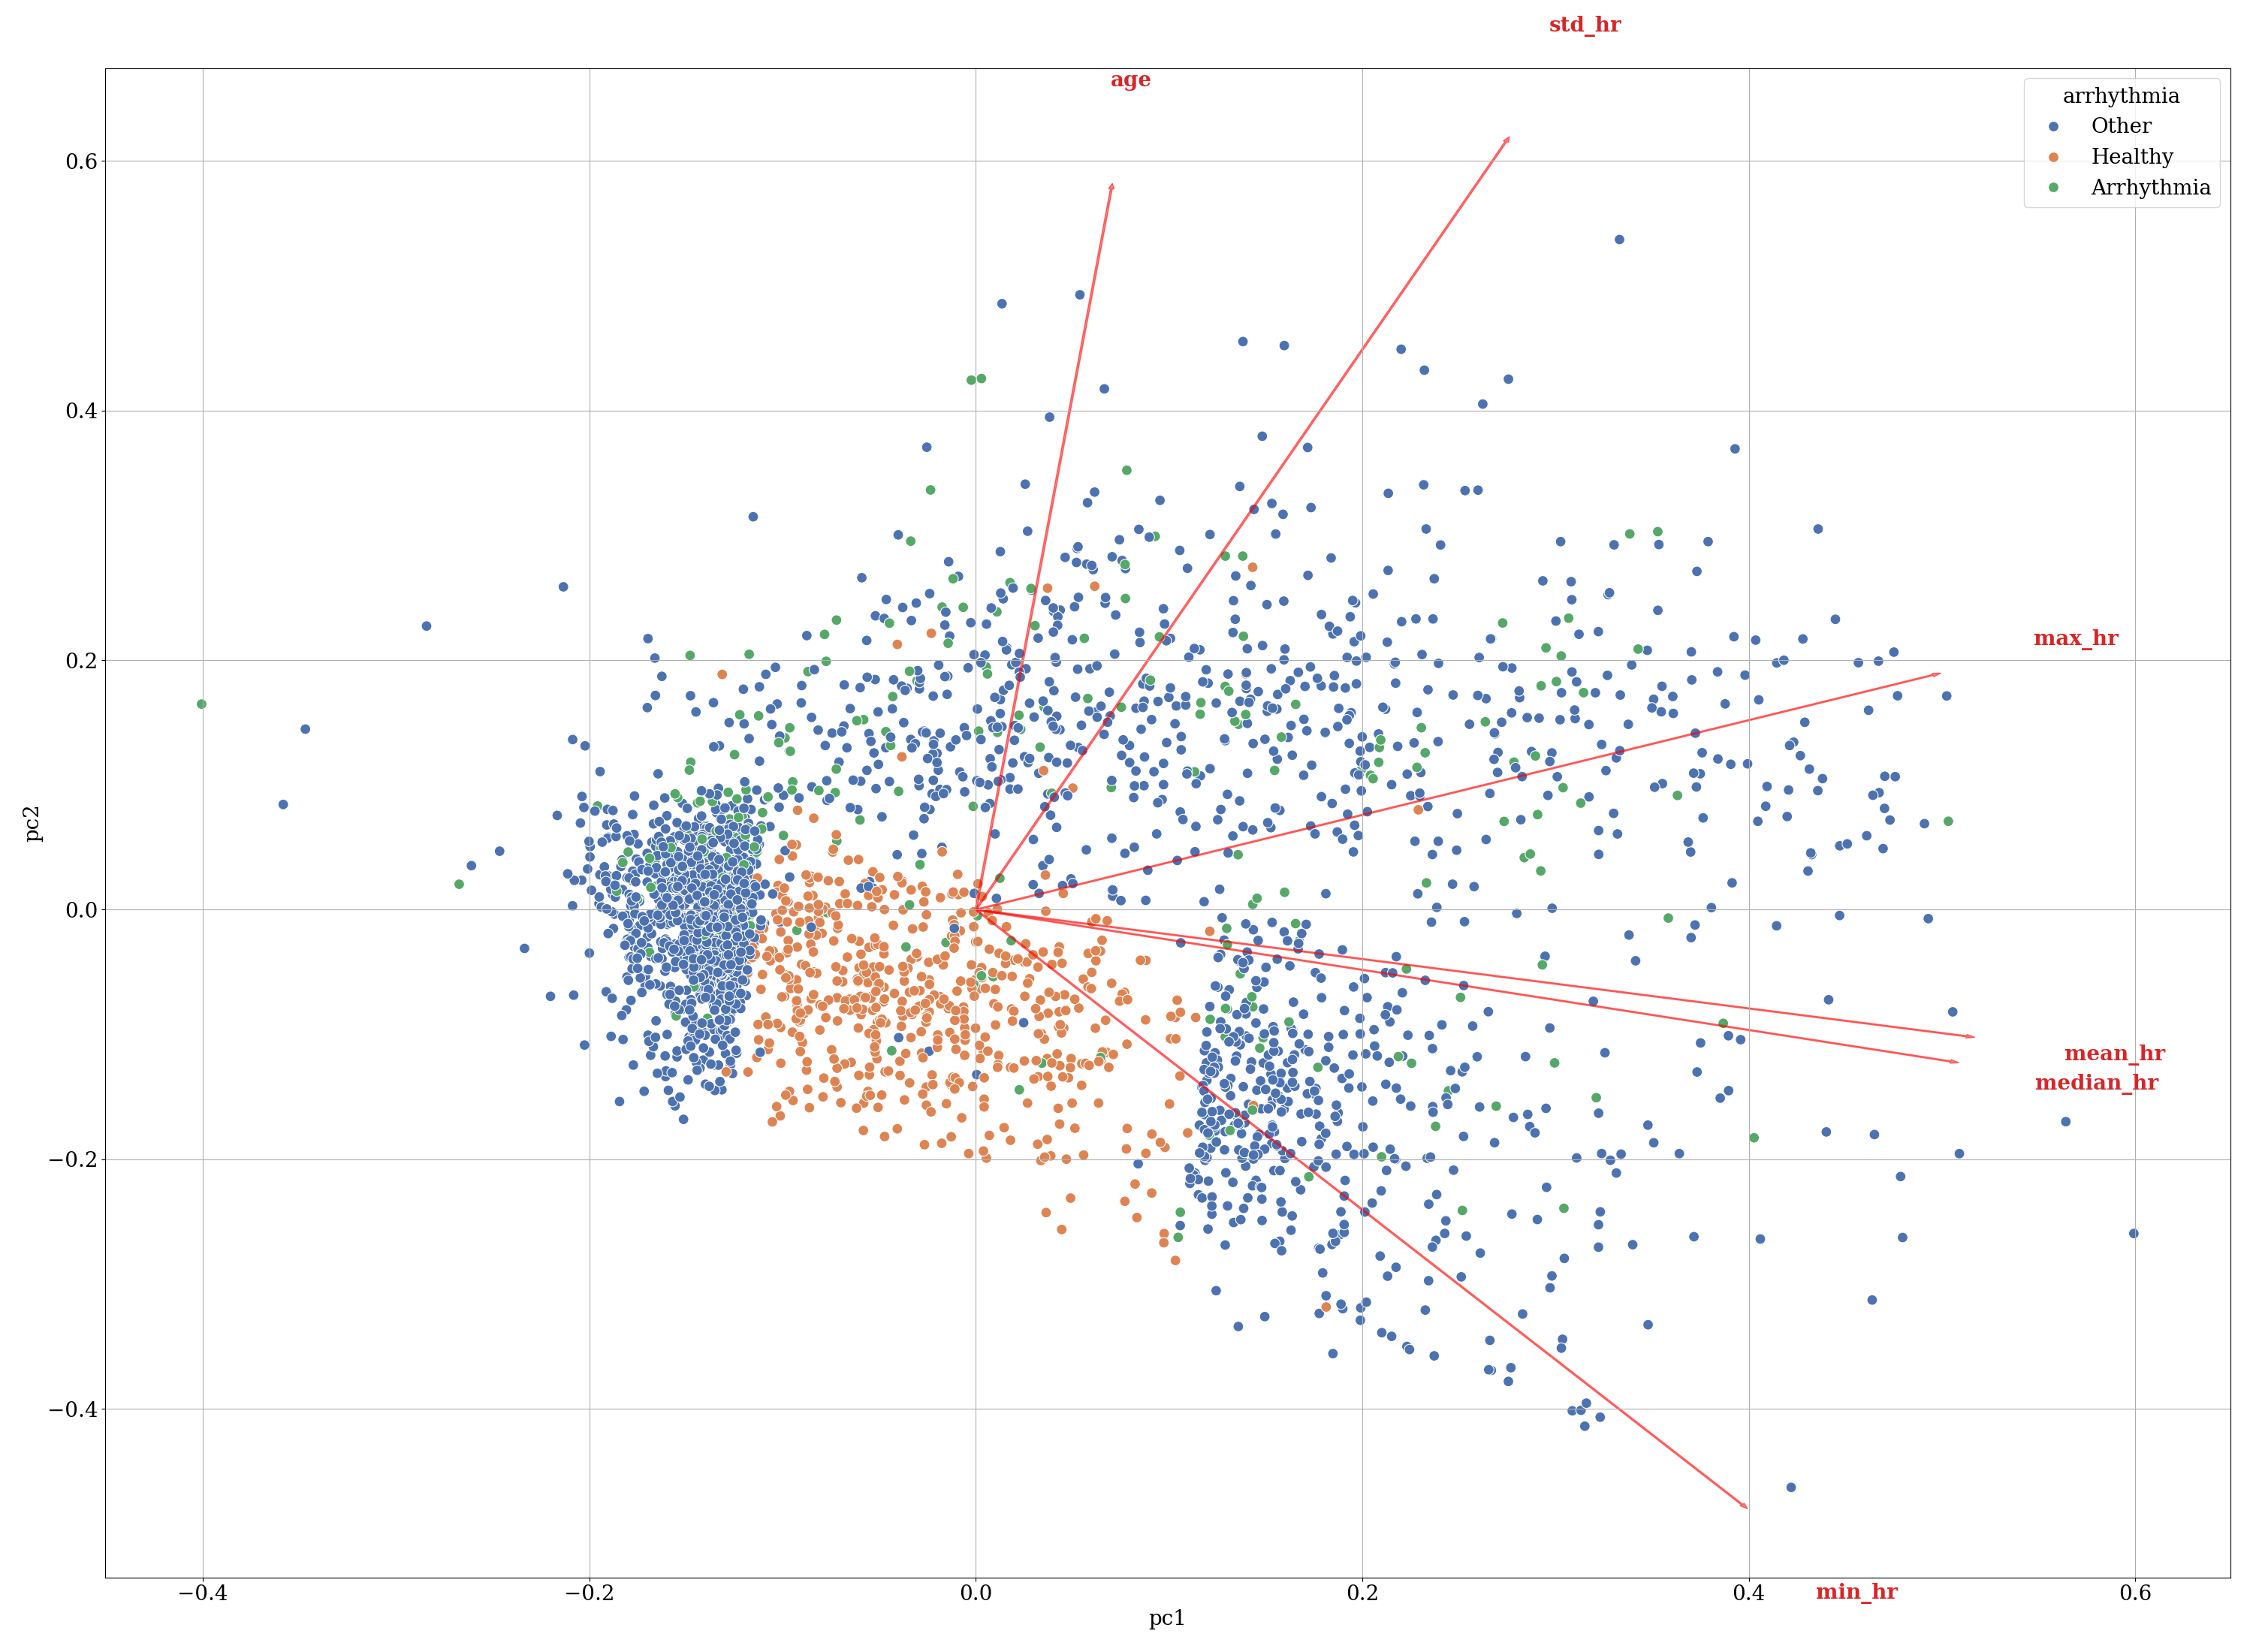

This goes inline with the PCA...

## Decision boundary display


Visualizing Decision Boundaries...
PCA-based boundaries:


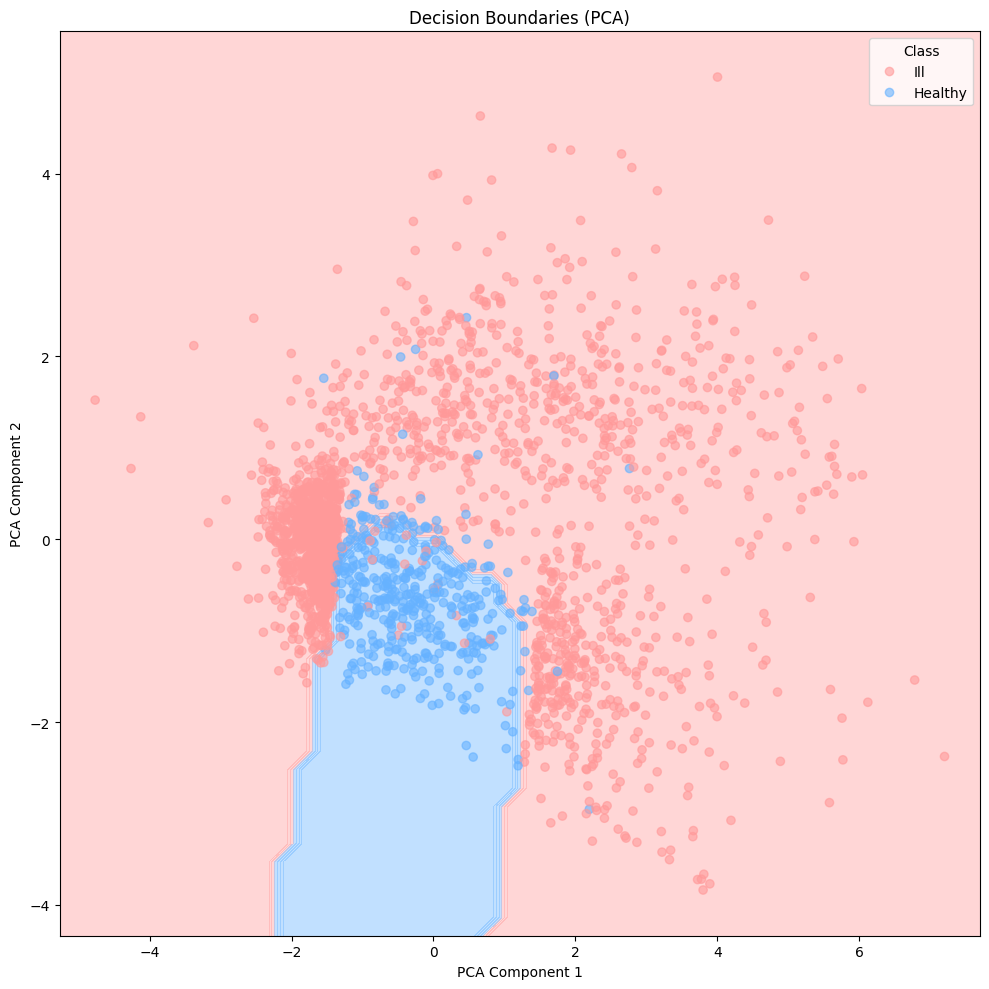

In [22]:
# Decision Boundary Analysis
print("\nVisualizing Decision Boundaries...")
model = analyzer.get_fitted_model(X_train, y_train)

print("PCA-based boundaries:")
boundary_viz = RF_pipeline.BoundaryVisualizer()
X_pca = boundary_viz.plot_boundaries_2d(X_train, y_train, model, method='pca')

## Shap values: 
- What favours arrythmia?

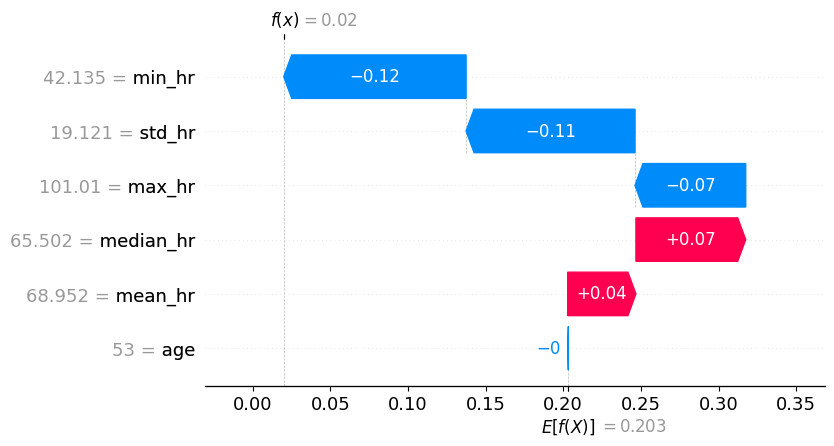

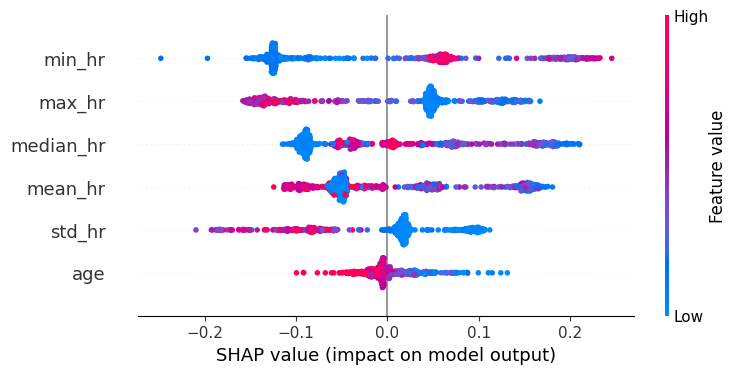

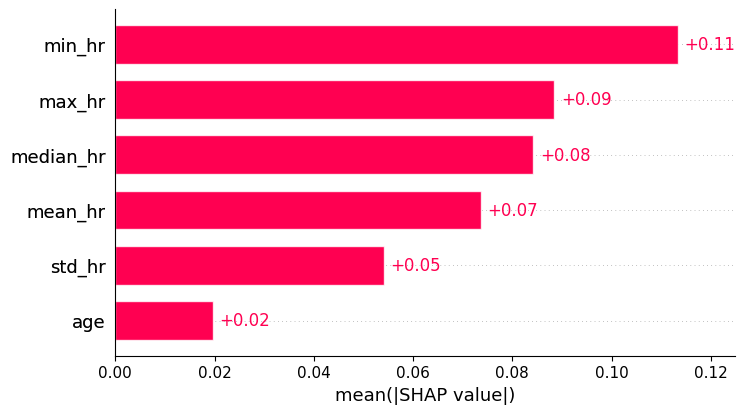

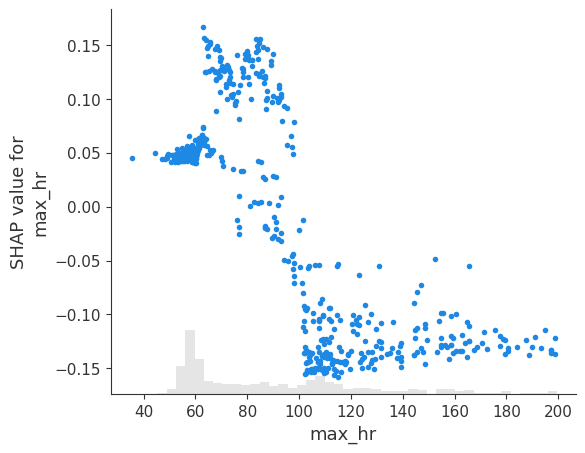

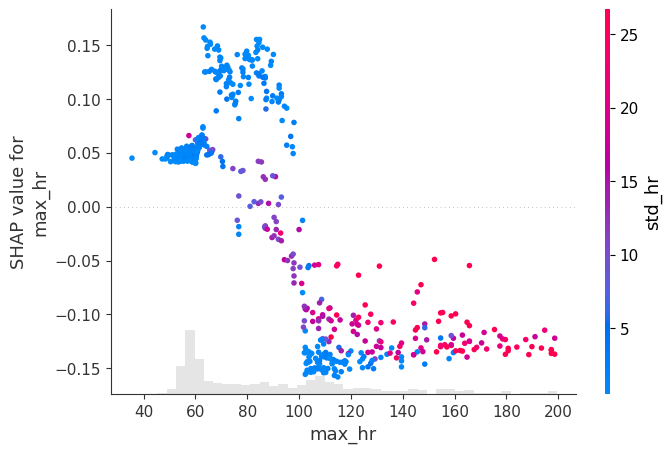

In [23]:
import shap


X_sub = shap.sample(X_train)
explainer = shap.Explainer(model.predict_proba, X_sub)
shap_values = explainer(X_test)

class_index = 1
data_index = 1

shap.plots.waterfall(shap_values[data_index,:,class_index], )

shap.initjs()
shap.plots.force(shap_values[data_index,:,class_index])

shap.plots.beeswarm(shap_values[:,:,class_index])

shap.plots.bar(shap_values[:,:,class_index])

shap.plots.scatter(shap_values[:, 'max_hr',1])

shap.plots.scatter(shap_values[:, 'max_hr',1], color=shap_values[:,:,1])

# DL CNN prediction: 
- Will we beat HRV RF classification? (With only 1 lead!)


## Pipeline Structure

### Training Phase
1. **Data Preparation**
  - Raw ECG dictionary + labels → `prepare_data()` → `normalize_signals()`
  - Train/val/test split
  - Dataset & DataLoader creation for batching

2. **Training Cycle**
  - DataLoader feeds batches to ModelTrainer
  - Forward pass through ECGNet
  - Loss calculation, backpropagation
  - Validation performance check
  - Save best model
  - Track metrics history

### Evaluation Phase
1. **Model Assessment**
  - Load best model weights
  - Full forward pass on test set
  - Generate predictions/probabilities

2. **Results**
  - Performance metrics calculation
  - Visualization generation
  - Save all results

## DL Architecture

### Input Processing
- 12-lead ECG signals
- 5000 timepoints per lead
- Normalized per lead

### Feature Extraction
- Conv1d (k=50): QRS complex detection
- Conv1d (k=7): Wave morphology
- Conv1d (k=5): Fine details
- Increasing channels (12→32→64→128) for feature hierarchy

### Each Conv Block
- BatchNorm: Training stability
- ReLU: Non-linearity
- MaxPool: Dimension reduction

### Classification
- AdaptivePool: Fixed output size
- FC layers (6400→256→64→2)
- Dropout layers prevent overfitting
- Output: Binary classification probabilities

Label encoding

In [24]:
# Prepare your labels
labels_dict = patient_data['Healthy'].reset_index(drop=False)
labels_dict = labels_dict.rename(columns={'Healthy':'label'})

# Save categories before encoding
categories = pd.Categorical(labels_dict['label']).categories

# Encode labels
labels_dict['label'] = pd.Categorical(labels_dict['label']).codes

# Create and print the encoding dictionary
encoding_dict = dict(enumerate(categories))

print("\nLabel encoding dictionary:")
for code, label in encoding_dict.items():
    print(f"{label} -> {code}")

print("\nLabel distribution:")
print(labels_dict['label'].value_counts())


Label encoding dictionary:
HEALTHY -> 0
ILL -> 1

Label distribution:
label
1    2454
0     543
Name: count, dtype: int64


### DL model loading (or training)

In [25]:
ecg_data['JS00067'].keys()

dict_keys(['ecg_signals', 'ecg_signals_filtered'])

Model file exists: True
Loading pretrained model from /Users/marcpalomer/Documents/Personal/ECG_prediction/Results/DL_model/results_20241214_202359/best_model.pth
Loading pre-trained model from /Users/marcpalomer/Documents/Personal/ECG_prediction/Results/DL_model/results_20241214_202359/best_model.pth

Test Set Performance:
              precision    recall  f1-score   support

           0       0.91      0.94      0.93       109
           1       0.99      0.98      0.98       491

    accuracy                           0.97       600
   macro avg       0.95      0.96      0.96       600
weighted avg       0.97      0.97      0.97       600



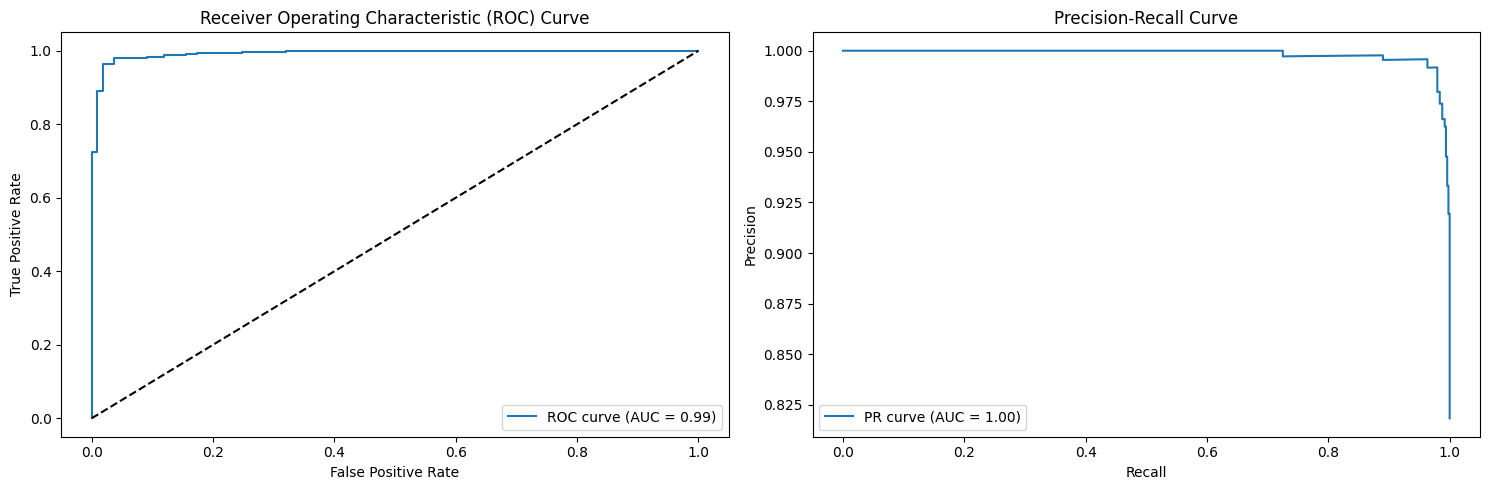

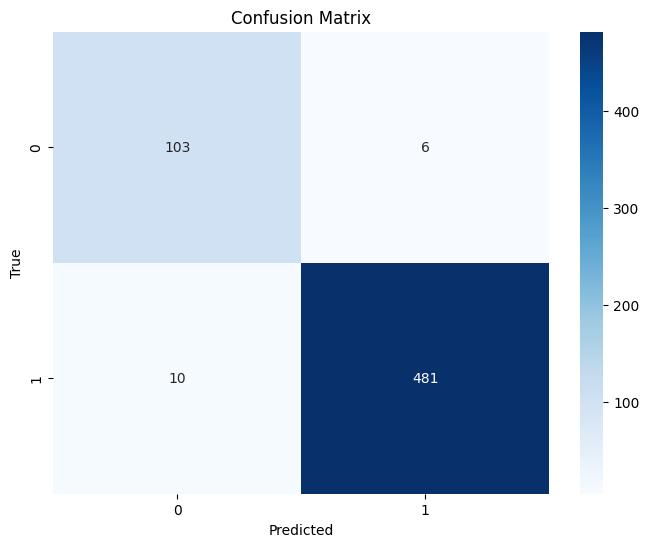


Analyzing ECG examples...

Results keys: dict_keys(['model', 'history', 'test_metrics', 'output_dir', 'importance_results', 'X_test', 'y_test'])

Results saved in: Results/DL_model/results_20241229_210713

Test Metrics:
ROC AUC: 0.9927
PR AUC: 0.9983
Test Loss: 0.0833


In [26]:
import importlib
import CNN
import traceback
import torch
import numpy as np
import pandas as pd
from pathlib import Path

# Reload the module to get the latest changes
importlib.reload(CNN)



# Verify model path
model_path = "/Users/marcpalomer/Documents/Personal/ECG_prediction/Results/DL_model/results_20241214_202359/best_model.pth"
print(f"Model file exists: {Path(model_path).exists()}")

# Configuration settings
config = {
    'batch_size': 32,
    'num_epochs': 50,
    'learning_rate': 0.001,
    'seed': 42
}

# Run the main function
try:
    print(f"Loading pretrained model from {model_path}")
    results = CNN.main(ecg_data, labels_dict, config, load_model_path=model_path)
    
    # Print results
    print("\nResults keys:", results.keys() if results else "No results")
    model = results['model']
    output_dir = results['output_dir']
    importance_results = results['importance_results']

    print(f"\nResults saved in: {output_dir}")
    if 'test_metrics' in results:
        print("\nTest Metrics:")
        print(f"ROC AUC: {results['test_metrics']['roc_auc']:.4f}")
        print(f"PR AUC: {results['test_metrics']['pr_auc']:.4f}")
        print(f"Test Loss: {results['test_metrics']['test_loss']:.4f}")

        
except Exception as e:
    print(f"Error occurred: {str(e)}")
    traceback.print_exc()

### External validation Performance

- Try performance on other 4 random directories of samples to assess actual performance of model

In [27]:
sorted([dir for dir in os.listdir(f"{dataset_dir}") if not dir.startswith('.')])[-3::]

['44', '45', '46']

In [38]:
external_validation_ecg_data = {}
external_validation_data = {}

# Loop through each record in the dataset directory
for directory1 in sorted([dir for dir in os.listdir(f"{dataset_dir}") if not dir.startswith('.')])[-10::-6]: #errase the [0:3] to get all the files
    for directory2 in sorted([dir for dir in os.listdir(f"{dataset_dir}/{directory1}") if not dir.startswith('.')]):
        for record_hea in [dir for dir in os.listdir(f"{dataset_dir}/{directory1}/{directory2}") if not dir.startswith('.')]:
            if record_hea.endswith(".hea"):  # Process .hea files
                try:
                    patient_id = record_hea.split(".hea")[0]
                    record_path = f"{dataset_dir}/{directory1}/{directory2}/{patient_id}"

                    # Read the header (.hea) file
                    record = wfdb.rdheader(record_path)

                    # Extract metadata
                    age = None
                    sex = None
                    diagnosis = None
                    for comment in record.comments:
                        if comment.startswith("Age:"):
                            age = comment.split(":")[1].strip()
                        if comment.startswith("Sex:"):
                            sex = comment.split(":")[1].strip()
                        if comment.startswith("Dx:"):
                            diagnosis = comment.split(":")[1].strip()  # This gives you the SNOMED codes
                    
                    # Read the 12-lead ECG signal from the .mat file
                    mat_file_path = f"{record_path}.mat"
                    mat_data = sio.loadmat(mat_file_path)
                    ecg_signals = mat_data['val']  # 'val' typically holds the ECG signal in PhysioNet datasets
                    ecg_signals= pd.DataFrame(ecg_signals.T, columns  = g_leads)
                    # Store the data in the dictionary
                    external_validation_ecg_data[patient_id] = {
                        "ecg_signals": ecg_signals,  # 12-lead ECG signals
                        }
                    external_validation_data[patient_id] = {
                        "diagnosis_code": [disease for disease in diagnosis.split(',')],  # Disease label (SNOMED codes)
                        "diagnosis_name": disease_map_func(diagnosis),
                        "age": age,
                        "sex": sex
                    }
                except Exception as e:
                    print(f"{patient_id}: {e}")

external_validation_data=pd.DataFrame(external_validation_data).T


JS36477: 55930002
JS36470: 55930002
JS36472: 251223006
JS36466: 55930002
JS36416: 365413008
JS36404: 55930002
JS36410: 55930002
JS36456: 365413008
JS36451: 365413008
JS36446: 55930002
JS36515: 365413008
JS36507: 55930002
JS36549: 55930002
JS36573: 55930002
JS36583: 55930002
JS36555: 55930002
JS36546: 365413008
JS36522: 55930002
JS36518: 365413008
JS36533: 55930002
JS36677: 55930002
JS36688: 55930002
JS36736: 365413008
JS36847: 55930002
JS36885: 55930002
JS36887: 55930002
JS36886: 251205003
JS36830: 55930002
JS36835: 55930002
JS36815: 365413008
JS36899: 55930002
JS36908: 55930002
JS36998: 446813000
JS36961: 55930002
JS36913: 55930002
JS36904: 55930002
JS36916: 55930002
JS37027: 55930002
JS37088: 365413008
JS37152: 55930002
JS37185: 55930002
JS37155: 55930002
JS37123: 55930002
JS37120: 55930002
JS37108: 55930002
JS37176: 365413008
JS37299: 55930002
JS37270: 55930002
JS37205: 55930002
JS37217: 55930002
JS37202: 55930002
JS37229: 55930002
JS37393: 55930002
JS37345: 55930002
JS37351: 559300

In [54]:
#applying filters
for patient in external_validation_ecg_data.keys():

    filtered_signal = external_validation_ecg_data[patient]['ecg_signals']#.apply(lambda x: signal.detrend(x))
    filtered_signal= filtered_signal.apply(lambda x:  signal.detrend(x))
    filtered_signal = filtered_signal.apply(lambda x: highpass_filter(data = x, cutoff=5, fs=fs))

    filtered_signal = filtered_signal.apply(lambda x: lowpass_filter(data = x, cutoff=140, fs=fs))
    filtered_signal = filtered_signal.apply(lambda x: scipy_notch_filter(data=x, frequency=50, fs=fs, quality=30))
    external_validation_ecg_data[patient]['ecg_signals_filtered'] = filtered_signal



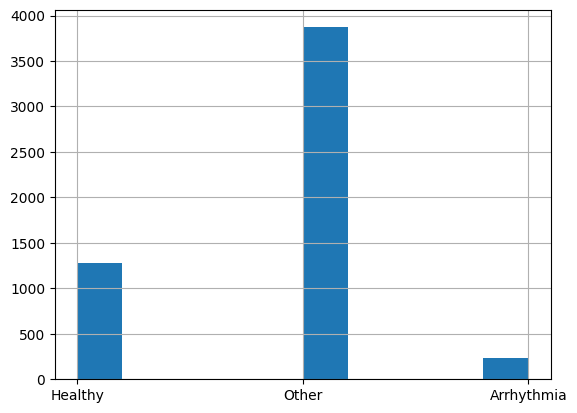

In [55]:
def classify_arrhythmia(diagnosis_codes):
   # Arrhythmia SNOMED codes
    #    snomed_codes = {
    #    'AF': '49436004',
    #    'RBBB': '59118001', 
    #    'LBBB': '28189009',
    #    'IAVB': '270492004',
    #    'PAC': '284470004',
    #    'PVC': '427172004',
    #    'MI': '22298006'
    #}
   arrhythmia_codes = ['49436004', '59118001', '28189009', '270492004', '284470004', '427172004', '22298006']
   
   # Sinus Rhythm Normal code
   healthy_code = '426783006'
   
   # Check if any arrhythmia code is present
   if any(code in diagnosis_codes for code in arrhythmia_codes):
       return 'Arrhythmia'
   # Check if healthy code present
   elif healthy_code in diagnosis_codes:
       return 'Healthy'
   # Otherwise other
   else:
       return 'Other'

# Apply to dataframe
external_validation_data['arrhythmia'] = external_validation_data['diagnosis_code'].apply(classify_arrhythmia)
external_validation_data['arrhythmia'].hist()
plt.show()

In [44]:
external_validation_data

diagnosis_code  \
JS36462                       [426783006]   
JS36476                       [426783006]   
JS36489                       [426783006]   
JS36488                       [426783006]   
JS36463                       [426783006]   
...                                   ...   
JS01001                       [426177001]   
JS01017                       [426783006]   
JS01003                       [426177001]   
JS01002             [426177001, 59118001]   
JS01016  [426177001, 55827005, 428750005]   

                                            diagnosis_name age     sex  \
JS36462                            [Sinus Rhythm (Normal)]  43    Male   
JS36476                            [Sinus Rhythm (Normal)]  16  Female   
JS36489                            [Sinus Rhythm (Normal)]  56    Male   
JS36488                            [Sinus Rhythm (Normal)]  39  Female   
JS36463                            [Sinus Rhythm (Normal)]  49  Female   
...                                                    ...  ..     ...   
JS01001                                [Sinus Bradycardia]  30  Female   
JS01017                            [Sinus Rhythm (Normal)]  20    Male   
JS01003                                [Sinus Bradycardia]  53  Female   
JS01002     [Sinus Bradycardia, right bundle branch block]  26    Male   
JS01016  [Sinus Bradycardia, Left Ventricular Hypertrop...  80  Female   

         arrhythmia  
JS36462     Healthy  
JS36476     Healthy  
JS36489     Healthy  
JS36488     Healthy  
JS36463     Healthy  
...             ...  
JS01001       Other  
JS01017     Healthy  
JS01003       Other  
JS01002  Arrhythmia  
JS01016       Other  

[5378 rows x 5 columns]

In [56]:
external_validation_labels_dict = external_validation_data['arrhythmia'].reset_index(drop=False)

external_validation_labels_dict['label'] = ['HEALTHY' if 'Health' in col else 'ILL' for col in external_validation_labels_dict['arrhythmia'] ]
external_validation_labels_dict

index  arrhythmia    label
0     JS36462     Healthy  HEALTHY
1     JS36476     Healthy  HEALTHY
2     JS36489     Healthy  HEALTHY
3     JS36488     Healthy  HEALTHY
4     JS36463     Healthy  HEALTHY
...       ...         ...      ...
5373  JS01001       Other      ILL
5374  JS01017     Healthy  HEALTHY
5375  JS01003       Other      ILL
5376  JS01002  Arrhythmia      ILL
5377  JS01016       Other      ILL

[5378 rows x 3 columns]

In [57]:


# Save categories before encoding
categories = pd.Categorical(external_validation_labels_dict['label']).categories

# Encode labels
external_validation_labels_dict['label'] = pd.Categorical(external_validation_labels_dict['label']).codes

# Create and print the encoding dictionary
encoding_dict = dict(enumerate(categories))

print("\nLabel encoding dictionary:")
for code, label in encoding_dict.items():
    print(f"{label} -> {code}")

print("\nLabel distribution:")
print(external_validation_labels_dict['label'].value_counts())


Label encoding dictionary:
HEALTHY -> 0
ILL -> 1

Label distribution:
label
1    4100
0    1278
Name: count, dtype: int64


In [58]:
external_validation_labels_dict

index  arrhythmia  label
0     JS36462     Healthy      0
1     JS36476     Healthy      0
2     JS36489     Healthy      0
3     JS36488     Healthy      0
4     JS36463     Healthy      0
...       ...         ...    ...
5373  JS01001       Other      1
5374  JS01017     Healthy      0
5375  JS01003       Other      1
5376  JS01002  Arrhythmia      1
5377  JS01016       Other      1

[5378 rows x 3 columns]

Model file exists: True
Loading pretrained model from /Users/marcpalomer/Documents/Personal/ECG_prediction/Results/DL_model/results_20241214_202359/best_model.pth
Loading pre-trained model from /Users/marcpalomer/Documents/Personal/ECG_prediction/Results/DL_model/results_20241214_202359/best_model.pth

Test Set Performance:
              precision    recall  f1-score   support

           0       0.97      0.92      0.95       256
           1       0.98      0.99      0.98       820

    accuracy                           0.97      1076
   macro avg       0.97      0.96      0.96      1076
weighted avg       0.97      0.97      0.97      1076



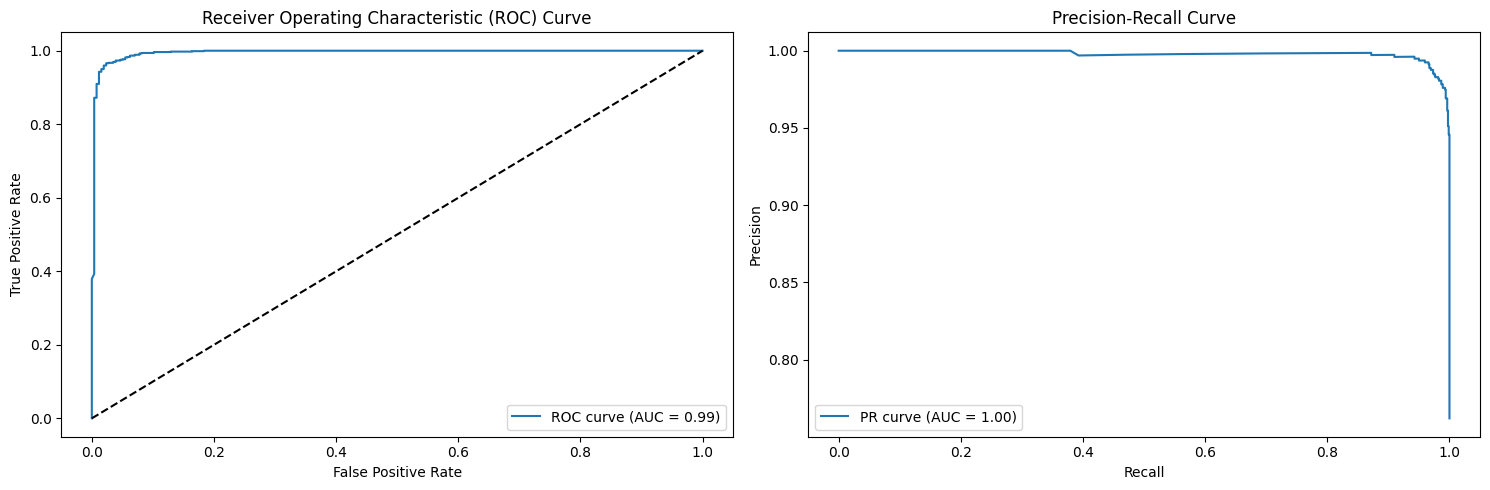

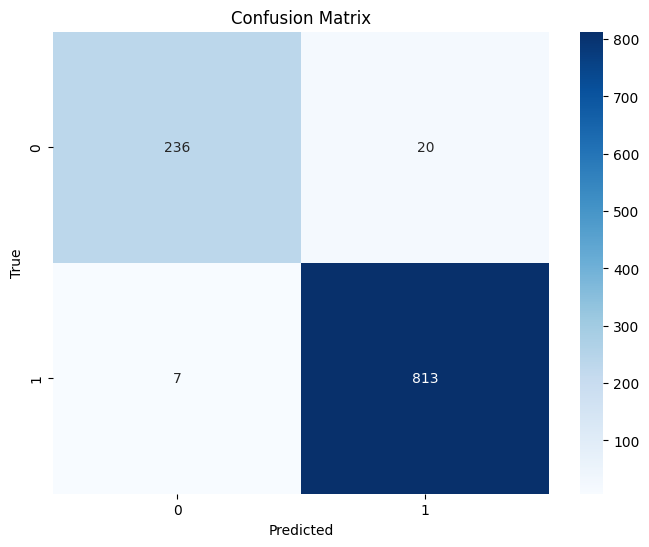


Analyzing ECG examples...

Results keys: dict_keys(['model', 'history', 'test_metrics', 'output_dir', 'importance_results', 'X_test', 'y_test'])

Results saved in: Results/DL_model/results_20241230_024013

Test Metrics:
ROC AUC: 0.9946
PR AUC: 0.9979
Test Loss: 0.0786


In [ ]:
import importlib
import CNN
import traceback
import torch
import numpy as np
import pandas as pd
from pathlib import Path

# Reload the module to get the latest changes
importlib.reload(CNN)



# Verify model path
model_path = "/Users/marcpalomer/Documents/Personal/ECG_prediction/Results/DL_model/results_20241214_202359/best_model.pth"
print(f"Model file exists: {Path(model_path).exists()}")

# Configuration settings
config = {
    'batch_size': 32,
    'num_epochs': 50,
    'learning_rate': 0.001,
    'seed': 42
}

# Run the main function
try:
    print(f"Loading pretrained model from {model_path}")
    results = CNN.main(external_validation_ecg_data, external_validation_labels_dict, config, load_model_path=model_path)
    
    # Print results
    print("\nResults keys:", results.keys() if results else "No results")
    model = results['model']
    output_dir = results['output_dir']
    importance_results = results['importance_results']

    print(f"\nResults saved in: {output_dir}")
    if 'test_metrics' in results:
        print("\nTest Metrics:")
        print(f"ROC AUC: {results['test_metrics']['roc_auc']:.4f}")
        print(f"PR AUC: {results['test_metrics']['pr_auc']:.4f}")
        print(f"Test Loss: {results['test_metrics']['test_loss']:.4f}")

        
except Exception as e:
    print(f"Error occurred: {str(e)}")
    traceback.print_exc()